# Imports and helper functions

In [173]:
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, LSTM
import numpy as np
from pandas import Series
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_process import ArmaProcess

TESTING = 'testing'
TRAINING = 'training'
INPUT = 'input'
OUTPUT = 'output'
TRAINING_PERCENTAGE = 0.8

# convert series to supervised learning set with inputs and outputs
def reshapedata(data: np.array, n_in: int, n_out: int) -> dict[np.array]:
    inarr = [np.array(data[i:i+n_in]) for i in range(len(data)-n_in-n_out+1)]
    outarr = [np.array(data[i:i+n_out]) for i in range(n_in, len(data)-n_out+1)]
    return {
        INPUT: np.array(inarr), 
        OUTPUT: np.array(outarr)
    }

# create function to split data into train and test sets
def splitdata(data: np.array, trainpercentage: float) -> tuple[np.array, np.array]:
    idx = int(len(data) * trainpercentage)
    return {
        TRAINING: data[0:idx], 
        TESTING: data[idx:len(data)]
    }

def predict_and_plot(indata: Series, model: Sequential, modelname: str, xlen: int, n_in: int, n_out: int) -> tuple[np.array, float]:
    data = np.array(indata.values)
    splitteddata = splitdata(data, TRAINING_PERCENTAGE)
    training_data = reshapedata(splitteddata[TRAINING], n_in, n_out)
    testing_data = reshapedata(splitteddata[TESTING], n_in, n_out)

    model.fit(training_data[INPUT], training_data[OUTPUT], epochs=100, verbose=0)
    predictions = model.predict(testing_data[INPUT], verbose=0)

    mse = mean_squared_error(predictions, testing_data[OUTPUT])

    training_idx = int(len(data) * TRAINING_PERCENTAGE)

    predictions_series = Series(
        predictions[:, 0], 
        index=indata.index[training_idx+n_in:training_idx+n_in+len(predictions)])
    plt.plot(indata, color='blue', linestyle='-', label='actual')
    plt.plot(predictions_series, color='red', linestyle='--', label='prediction')
    plt.title(f"{modelname} with MSE = {format(mse, '.6f')}")
    plt.axvline(TRAINING_PERCENTAGE * xlen, color='black', linestyle='--')
    plt.xlim(indata.index[int(0.5*len(indata.index))], indata.index[len(indata.index) - 1])
    plt.show()

# create a function that performs the plotting part of the above function
def plotdata(indata: Series, prediction: Series, title: str, xlen: int, n_in: int) -> None:
    training_idx = int(len(indata) * TRAINING_PERCENTAGE)
    predictions_series = Series(
        prediction[:, 0], 
        index=indata.index[training_idx+n_in:training_idx+n_in+len(prediction)])

    plt.plot(indata, color='blue', linestyle='-', label='actual')
    plt.plot(predictions_series, color='red', linestyle='--', label='prediction')
    plt.title(title)
    plt.axvline(TRAINING_PERCENTAGE * xlen, color='black', linestyle='--')
    plt.xlim(indata.index[int(0.5*len(indata.index))], indata.index[len(indata.index) - 1])
    plt.show()

def predictdata(indata: Series, model: Sequential, n_in: int, n_out: int) -> tuple[np.array, float]:
    data = np.array(indata.values)
    splitteddata = splitdata(data, TRAINING_PERCENTAGE)
    training_data = reshapedata(splitteddata[TRAINING], n_in, n_out)
    testing_data = reshapedata(splitteddata[TESTING], n_in, n_out)

    model.fit(training_data[INPUT], training_data[OUTPUT], epochs=100, verbose=0)
    predictions = model.predict(testing_data[INPUT], verbose=0)
    mse = mean_squared_error(predictions, testing_data[OUTPUT])
    
    return predictions, mse

# Task 1.1 - Prediction with MLP, RNN, LSTM using synthetic series

## Sub-task 1
An equal-difference series starting from 0, ending to 1 (excluding 1), with a length of 200 points (step = 0.005).
Design an MLP for one-step prediction. The output vector has a size of 1. Let the input vector be a size of 4.

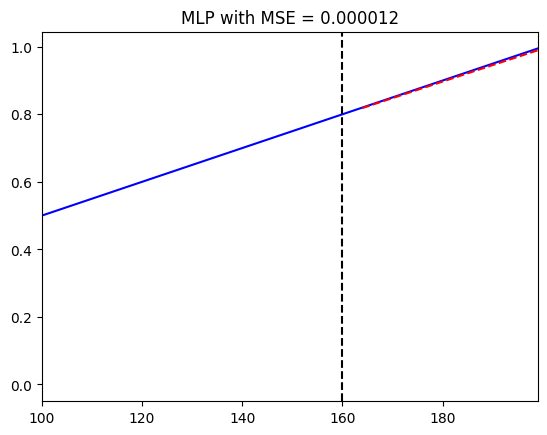

In [174]:
# Multi level perceptron (MLP) including hidden layer (100) and an output layer with 1 neuron
model = Sequential([
    Dense(100, activation='relu', input_dim=4),
    Dense(1)
]).compile(optimizer='adam', loss='mse')

data = Series(np.arange(0, 1, 0.005))

pred2, mse2 = predictdata(data, model, 4, 1)
plotdata(data, pred2, f"MLP with MSE = {format(mse2, '.6f')}", len(data), 4)

## Sub-task 2
An equal-difference series starting from 0, ending to 1, with a length of 200 points (step = 0.005), plus white noise i.e., random variable with zero mean and 1 variance. You may need to control the amplitude of the noise series in order to control the signal-noise ratio.
Design an MLP for one-step prediction. The output vector has a size of 1. Let the input vector be a size of 4.

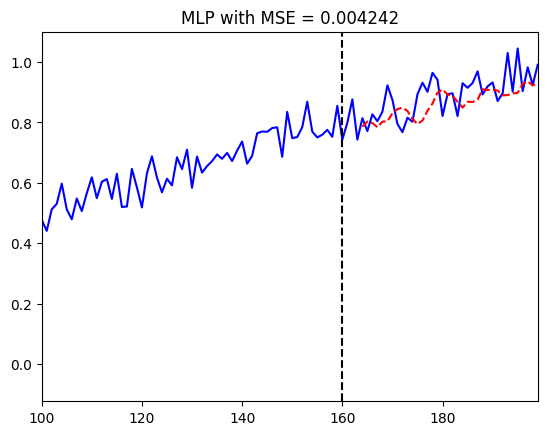

In [175]:
# model hidden layer with 100 neurons and output layer with 1 neuron
model = Sequential([
    Dense(100, activation='relu', input_dim=4),
    Dense(1)
]).compile(optimizer='adam', loss='mse')

data = Series(np.arange(0, 1, 0.005)) 
data += np.random.normal(0, 0.05, data.shape)

pred, mse = predictdata(data, model, 4, 1)
plotdata(data, pred, f"MLP with MSE = {format(mse, '.6f')}", len(data), 4)

## Sub-task 3
A deterministic series sampled from a sinusoidal wave with period 20 seconds, with a sample rate of 100 Hz. Generate sufficient samples (at least 3 periods of data) as needed to achieve good performance, e.g. MSE (mean squared error) below 0.5.

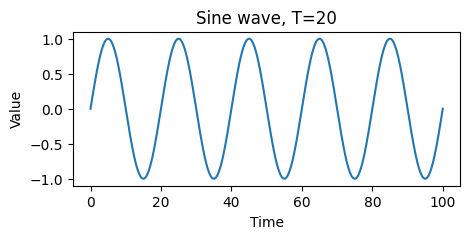

In [176]:
period = 20
periods = 5
sample_rate = 100

timestamps = np.linspace(0, periods * period, sample_rate * periods)
sinedata = Series(timestamps).map(lambda t: np.sin(2*np.pi / period * t))
sinedata.index = timestamps
sinedata.plot(figsize=(5, 2), kind='line', xlabel='Time', ylabel='Value', title='Sine wave, T=20')
plt.show()

Design an RNN and a LSTM for two-step prediction. The output vector has a size of 2. Set the input vector size by yourself.

### RNN model

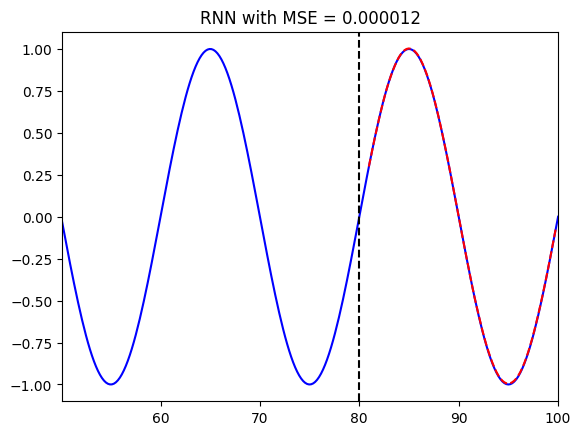

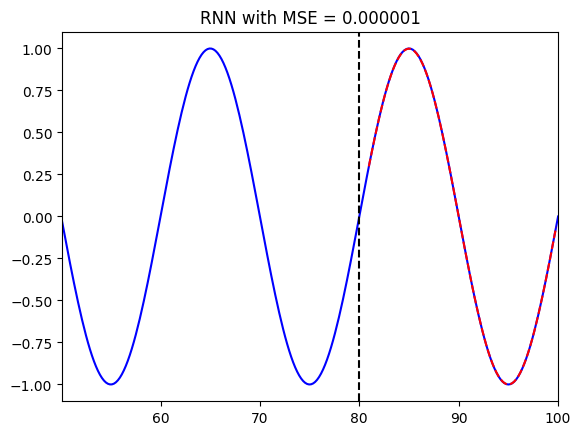

In [177]:
model = Sequential([
    SimpleRNN(units=100, input_shape=(4, 1), activation='relu'),
    Dense(units=2)
]).compile(optimizer='adam', loss='mse')

pred, mse = predictdata(sinedata, model, 4, 2)
plotdata(sinedata, pred, f"RNN with MSE = {format(mse, '.6f')}", periods * period, 4)


### LSTM model

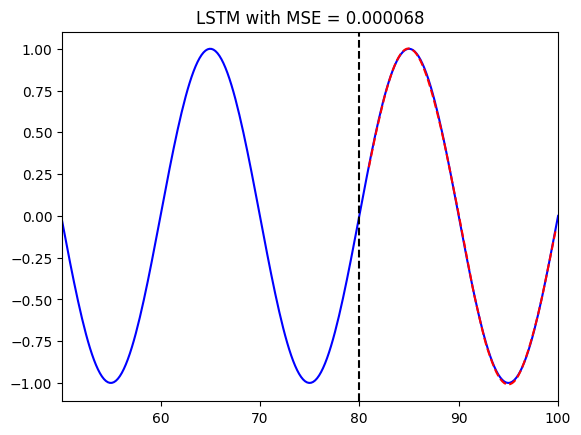

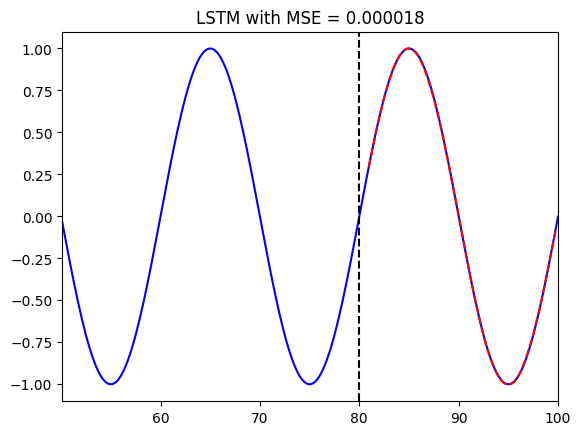

In [178]:
model = Sequential([
    LSTM(units=100, input_shape=(4, 1), activation='relu'),
    Dense(units=2)
]).compile(optimizer='adam', loss='mse')

predict_and_plot(sinedata, model, 'LSTM', periods * period, 4, 2)
pred, mse = predictdata(sinedata, model, 4, 2)
plotdata(sinedata, pred, f"LSTM with MSE = {format(mse, '.6f')}", periods * period, 4)


## Sub-task 4
A stochastic series sampled from a sinusoidal wave with period 20 seconds, with a sample rate of 100 Hz, plus random white noise i.e., random variable with zero mean and 1 variance. Control the amplitude of the noise with a fractional number, e.g. 0.1.

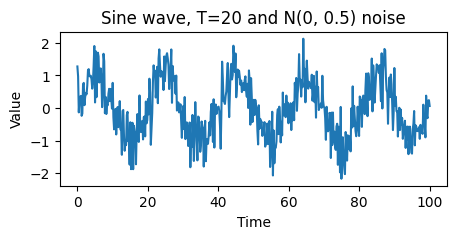

In [179]:
period = 20
periods = 5
sample_rate = 100

timestamps = np.linspace(0, periods * period, sample_rate * periods)
sinedatawnoise = Series(timestamps).map(lambda t: np.sin(2*np.pi / period * t))
sinedatawnoise += np.random.normal(0, 0.5, sinedatawnoise.shape)
sinedatawnoise.index = timestamps
sinedatawnoise.plot(figsize=(5, 2), kind='line', xlabel='Time', ylabel='Value', title='Sine wave, T=20 and N(0, 0.5) noise')
plt.show()

Design an RNN and a LSTM for two-step prediction. The output vector has a size of 2. Set the input vector size by yourself.

### RNN model

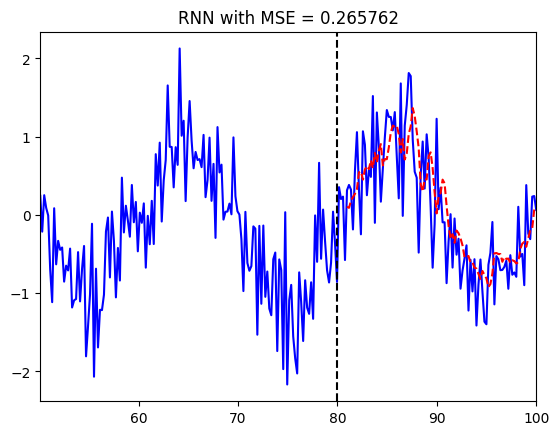

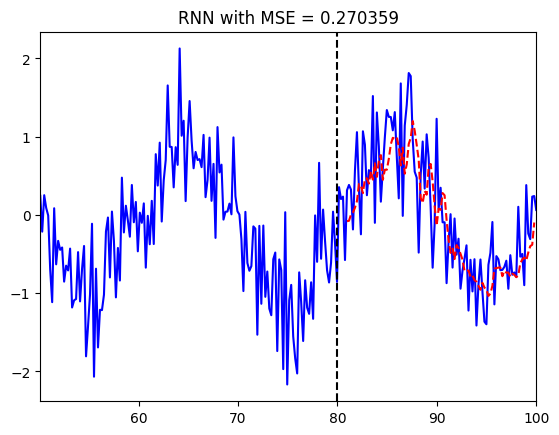

In [181]:
model = Sequential([
    SimpleRNN(units=100, input_shape=(4, 1), activation='sigmoid'),
    Dense(units=2)
]).compile(optimizer='adam', loss='mse')

pred, mse = predictdata(sinedatawnoise, model, 4, 2)
plotdata(sinedatawnoise, pred, f"RNN with MSE = {format(mse, '.6f')}", periods * period, 4)

### LSTM model

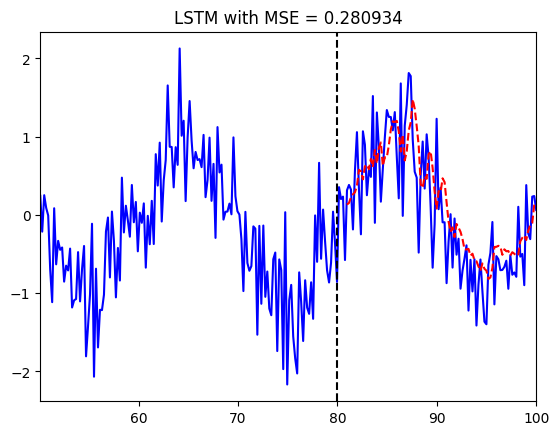

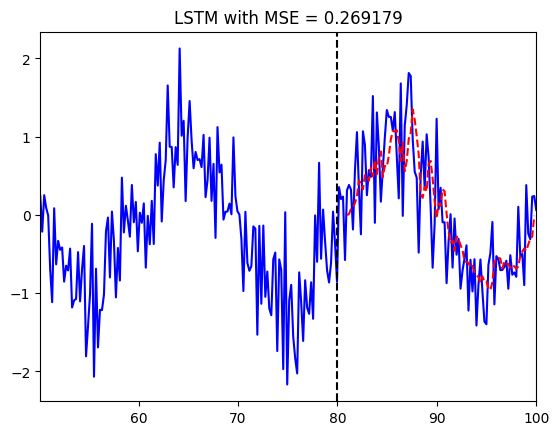

In [180]:
model = Sequential([
    LSTM(units=100, input_shape=(4, 1), activation='sigmoid'),
    Dense(units=2)
])
model.compile(optimizer='adam', loss='mse')

pred, mse = predictdata(sinedatawnoise, model, 4, 2)
plotdata(sinedatawnoise, pred, f"LSTM with MSE = {format(mse, '.6f')}", periods * period, 4)

# Task 1.2 - Predict white noise, a random walk and an ARMA process using neural networks

The dataset for this task should include the following three patterns of data, 1000 points in each
- A pure white-noise series with 1000 data points
- A random-walk series.
- A stationary series generated by an ARMA(2, 2) process. Make sure that the process with right parameters generates a stationary series.

ARMA process is stationary
AR coefficients: [ 0.5 -0.5], MA coefficients: [0.5 0.5]


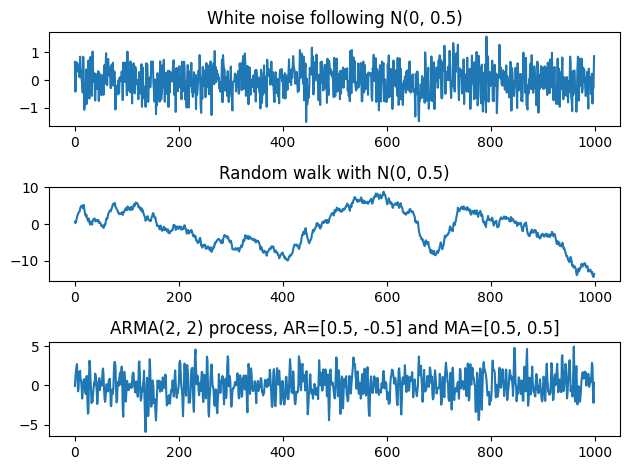

In [90]:
SAMPLE_SIZE = 1000
wnoiseseries = Series(np.random.normal(0, 0.5, SAMPLE_SIZE))
rwseries = Series(wnoiseseries.cumsum())
arcoeffs = np.array([0.5, -0.5])
macoeffs = np.array([0.5, 0.5])
proc = ArmaProcess(ar=np.r_[1, -arcoeffs], ma=np.r_[1, macoeffs])
armaseries = Series(proc.generate_sample(nsample=SAMPLE_SIZE))

fig, axes = plt.subplots(3, 1)
axes[0].plot(wnoiseseries)
axes[0].set_title('White noise following N(0, 0.5)')
axes[1].plot(rwseries)
axes[1].set_title('Random walk with N(0, 0.5)')
axes[2].plot(data)
axes[2].set_title('ARMA(2, 2) process, AR=[0.5, -0.5] and MA=[0.5, 0.5]')
plt.tight_layout()
print(f"ARMA process is {'stationary' if proc.isstationary else 'not stationary'}")
print(f"AR coefficients: {arcoeffs}, MA coefficients: {macoeffs}")
plt.show()

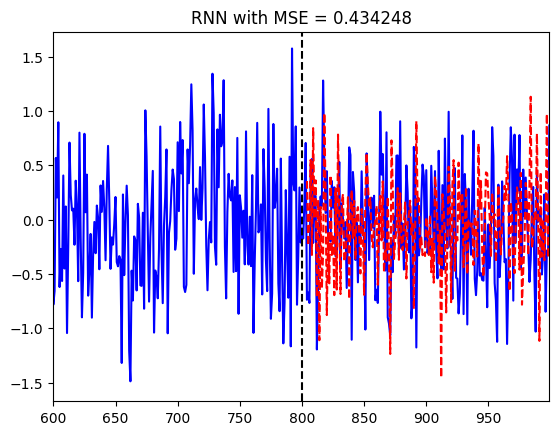

In [150]:
model = Sequential([
    SimpleRNN(units=100, input_shape=(4, 1), activation='relu'),
    Dense(units=100, activation='linear'),
    Dense(units=100, activation='sigmoid'),
    Dense(units=100, activation='sigmoid'),
    Dense(units=1)
])
model.compile(optimizer='adam', loss='mse')

predict_and_plot(Series(wnoiseseries), model, 'RNN', SAMPLE_SIZE, 4, 1)